In [66]:
import pandas as pd
from datetime import datetime as dt

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../../data/household_power_consumption.txt',
                 sep=';',na_values = '?')

# Retaining data only from year 2010
df = df[df['Date'].isin([s for s in df['Date'].values if '2010' in s])].reset_index(drop=True)

# Removing all null rows
df = df.loc[df[df.isnull().sum(axis=1) == 0].index,:]

# Converting Date and Time columns into a datetime object and setting that as th index
df['Datetime'] = df.apply(lambda x: ' '.join([x['Date'],x['Time']]),axis=1)
df.index = pd.to_datetime(df['Datetime'],format='%d/%m/%Y %H:%M:%S')
df['Datetime'] = pd.to_datetime(df['Datetime'],format='%d/%m/%Y %H:%M:%S')
df.index.name = 'datetime'
df.drop(labels = ['Date','Time'],axis=1,inplace = True)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
datetime,,,,,,,,
2010-01-01 00:00:00,1.790,0.236,240.65,7.4,0.0,0.0,18.0,2010-01-01 00:00:00
2010-01-01 00:01:00,1.780,0.234,240.07,7.4,0.0,0.0,18.0,2010-01-01 00:01:00
2010-01-01 00:02:00,1.780,0.234,240.15,7.4,0.0,0.0,19.0,2010-01-01 00:02:00
2010-01-01 00:03:00,1.746,0.186,240.26,7.2,0.0,0.0,18.0,2010-01-01 00:03:00
2010-01-01 00:04:00,1.686,0.102,240.12,7.0,0.0,0.0,18.0,2010-01-01 00:04:00


In [ ]:
# Visualize percent change, 

<AxesSubplot:xlabel='datetime'>

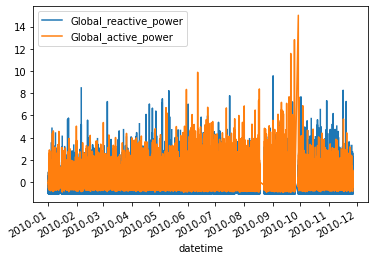

In [11]:
df[['Global_reactive_power', 'Global_active_power']].pct_change().plot()

## Relationship between $R^2$ and Correlation

- $[corr(x, y)]^2$  = $R^2$: The magnitude of the correlation is the $\sqrt{R^2}$
- sign(corr) = sign(regression slope aka $\beta$)
For example:
- If $R^2$ = 0.753
- Slope is +ve
- correlation is $+\sqrt{0.753} = 0.868$

The dataframe contains readings every 2 mins.
Lets down sample to get reading every 2 hours

In [21]:
df.Global_active_power.head()

datetime
2010-01-01 00:00:00    1.790
2010-01-01 00:01:00    1.780
2010-01-01 00:02:00    1.780
2010-01-01 00:03:00    1.746
2010-01-01 00:04:00    1.686
Name: Global_active_power, dtype: float64

## Autocorrelation
   - What is autocorrelation (aka serial correlation)?
       - Correlation of a time series with a lagged copy of itself.
       
When lagged copy is negatively correlated with the time series, it is called __Mean Reversion__; when it is positively correlated, it is called __Momentum__ or __Trend Following__.

## Autocorrelation Function (ACF)
   - The autocorrelation as a function of lag.

In [42]:
from statsmodels.graphics.tsaplots import plot_acf

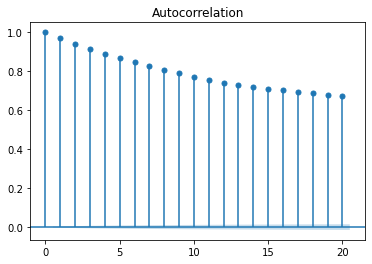

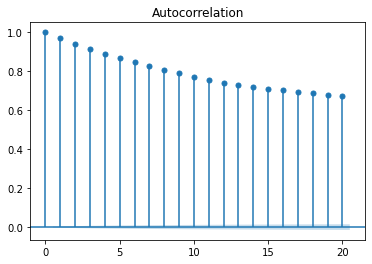

In [49]:
plot_acf(df[['Global_active_power']],lags=20,alpha = 0.05)

At the original sampling rate, the `Global_active_power` reading is significantly correlated with its previous 20 readings. 

See the actuall acf values for the lag of 20.

In [48]:
from statsmodels.tsa.stattools import acf

In [51]:
acf(df['Global_active_power'])

array([1.        , 0.97107126, 0.94111918, 0.91519445, 0.88978454,
       0.86586984, 0.84535289, 0.82545662, 0.80622096, 0.78883592,
       0.77229599, 0.75569228, 0.74166079, 0.72957697, 0.71884587,
       0.70987237, 0.70188991, 0.69353841, 0.68576949, 0.67879719,
       0.67128437, 0.6639394 , 0.65688205, 0.6493694 , 0.64184795,
       0.63482839, 0.62746718, 0.61996014, 0.61305096, 0.60617417,
       0.59891273, 0.59202236, 0.58535156, 0.57848885, 0.57210216,
       0.56608086, 0.55999076, 0.55372267, 0.54805657, 0.54245316,
       0.5367025 ])

Let's downsample the data to obtain reading every 1 hour, and plot its autocorrelation along with 95% CI band.

In [55]:
df_hourly = df.resample(rule='1H').last()

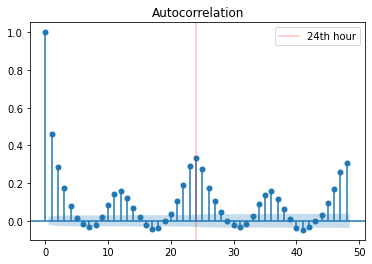

In [165]:
_=plot_acf(df_hourly['Global_active_power'].dropna(),lags=48)
_=plt.axvline(24,c='red',alpha=0.25,label='24th hour')
_=plt.legend()

There is significant correlation between the current Global_active_power reading and the readings at 2,3,11-13,21-27, and 34-38 hours prior. 

There is a week cyclical pattern every 12 hours and a strong cyclical pattern every 24 hours.

## White noise
   - What is White Noise?
    - White Noise is a series with:
        - Constant mean
        - Constant variance
        - Zero autocorrelation at all lags
        
   - There are several special cases of white noise. One of them is _Gaussian White Noise_ if the data is normally distributed.

## Simulating White Noise

In [63]:
import numpy as np
noise = np.random.normal(loc=0,scale=1,size=500)

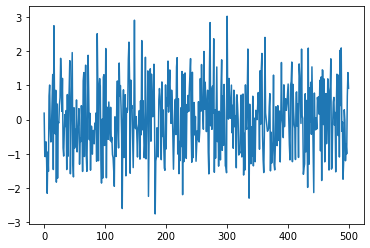

In [67]:
plt.plot(noise)

Check if all the autocorrelation of the simulated white noise is 0.

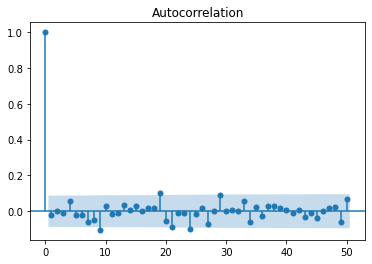

In [70]:
_=plot_acf(noise,lags=50,alpha=0.05)

Yes, they are!

## Random Walk

- What is a Random Walk?
    - Today's price = Yesterday's Price + Noise  
    $P_{t} = P_{t-1} + \epsilon_{t}$
    
    - Change in price in a random walk is white noise  
    $P_{t} - P_{t-1} = \epsilon_{t}$
    
Point is: If the stock prices follow a random walk then stock returns are white noise. 
- Can't forcast a randomwalk
- Best guess for tomorrow's price is today's price
- Random walk with drift:  
$P_{t} = \mu + P_{t-1} + \epsilon_{t}$
- Change in price is white noise with non-zero mean:  
$P_{t}-P_{t-1} = \mu + \epsilon_{t}$

## Statistical Test for Random Walk

- Random walk with drift  
$P_{t} = \mu + P_{t-1} + \epsilon_{t}$

- Regression test for random walk  
$P_{t}  = \alpha + \beta P_{t-1} + \epsilon_{t}$

- Test:
    - series is a random walk: $H_{0}: \beta = 1$  
    - series is __NOT__ a random walk: $H_{1}: \beta < 1$  

    - If $\beta$ is not significantly different from 1, then we cannot reject the $H_{0}$. However, if the $\beta$ is significantly less than 1, then we can reject the $H_{0}$.
    
- The following test is also equivalent:
$P_{t} - P_{t-1} = \alpha + \beta P_{t-1} + \epsilon_{t}$
    - However, the null and alternative hypotheses are as follows:  
        $H_{0}: \beta = 0$ (random walk)   
        $H_{1}: \beta < 0$ (NOT random walk)  
    - This test is called __Dicky-Fuller__ test. 
    
- Lets use adfuller function to test whether Global_active_power is random walk or not.   

In [72]:
from statsmodels.tsa.stattools import adfuller

In [84]:
results = adfuller(df_hourly['Global_active_power'].dropna())

In [85]:
print(results)

(-8.899997848862391, 1.1784130604277724e-14, 24, 7602, {'1%': -3.4312104984842975, '5%': -2.861920275934168, '10%': -2.5669724164046337}, 18016.10634967263)


In [86]:
print('Test p-value: %.3f'%(results[1]))

Test p-value: 0.000


Since the p-value is < 0.05, there is strong evidence to reject the null hypothesis that hourly Global_active_power is a randwalk.

## Stationarity

- What is stationarity?
    - Strong stationarity: entire distribution of data is time-invariant
    - Weak stationarity: mean, variance and autocorrelation are time-invariant (i.e., for autocorrelation, $corr(X_{t},X_{t-\tau})$ is only a function $\tau$)
    
    
- Why do we care?
    - If a process is not stationary, it becomes difficult to model  
    - If parameters vary with time, too many parameters to estimate
    - Can only estimate a parsimonious model with a few parameters
    
    
- Examples of Non-stationary Series  
    - A random walk (stock prices)
    - Seasonality in series

We can remove the 24 hour periodicity from the hourly readings of Global_active_power to make it stationary. This can be done by taking the 12th difference of the hourly readings.

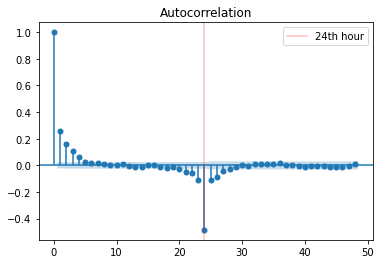

In [142]:
df_hourly_24diff = df_hourly.diff(24).dropna()
_=plot_acf(df_hourly_24diff['Global_active_power'],lags=48)
_=plt.axvline(24,c='red',alpha=0.25,label='24th hour')
_=plt.legend()

## AR Model
- Mathematical Description of AR(1) Model
$$ R_{t} = \mu + \phi R_{t-1} + \epsilon_{t}$$

- Since only one lagged value on the right hand side, this is called:
    - AR model of order 1, or
    - AR(1) model
- AR parameter ($\phi$) = 1, then the process is a random walk; if $\phi = 0$, then process is white noise (i.e., stationary process)
- For stationarity, -1 < $\phi$ < 1

- Interpretation of AR(1) parameter
    - Negative $\phi$: Mean Reversion
    - Positive $\phi$: Momentum (or Trend Following)

## Simulating an AR process

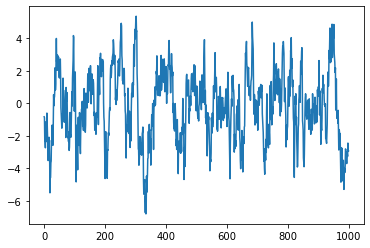

In [177]:
from statsmodels.tsa.arima_process import ArmaProcess

ar = np.array([1, -0.9]) # where 1 is the zero-lag coefficient and -0.9 is coeffn. for 1-lag
ma = np.array([1])
AR_object = ArmaProcess(ar,ma)
simulated_data = AR_object.generate_sample(nsample=1000)
plt.plot(simulated_data)

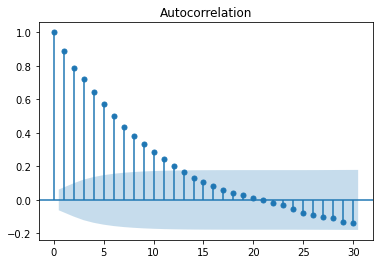

In [178]:
_=plot_acf(simulated_data)

## Estimating and Forcasting AR model

In [179]:
from statsmodels.tsa.arima_model import ARMA

In [184]:
mod = ARMA(simulated_data, order=(1,0)) # order = (AR, MA)
results = mod.fit()

In [187]:
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1405.689
Method:                       css-mle   S.D. of innovations              0.986
Date:                Tue, 29 Dec 2020   AIC                           2817.378
Time:                        16:46:06   BIC                           2832.101
Sample:                             0   HQIC                          2822.974
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2257      0.275     -0.821      0.412      -0.764       0.313
ar.L1.y        0.8874      0.015     61.113      0.000       0.859       0.916
                                    Roots           

The coefficient for the mean ($\mu$) is close to 0 and AR parameter ($\phi$) is close to 0.9

## Forcasting with an AR Model

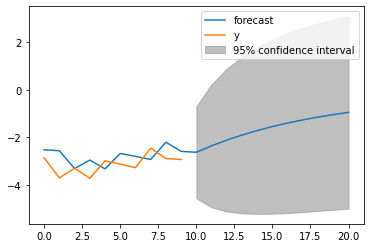

In [188]:
# Import the ARMA module from statsmodels

# Forecast the first AR(1) model
mod = ARMA(simulated_data, order=(1,0))
res = mod.fit()
res.plot_predict(start=990, end=1010)
plt.show()

## Choosing the Right Model
- Identifying the Order of an AR Model
    - The order of an AR(p) model will usually be unknown
    - Two techniques to determine order
        - Partial Autocorrelation Function
        - Information criteria
        
- Partial Autocorrelation Function (PACF)  
$R_{t} = \phi_{0,1} + \phi_{1,1} R_{t-1} + \epsilon_{1t}$  
$R_{t} = \phi_{0,1} + \phi_{1,1} R_{t-1} + \phi_{2,2} R_{t-1} + \epsilon_{2t}$  
$R_{t} = \phi_{0,1} + \phi_{1,1} R_{t-1} + \phi_{2,2} R_{t-1} + \phi_{3,3} R_{t-1} + \epsilon_{3t}$  
$R_{t} = \phi_{0,1} + \phi_{1,1} R_{t-1} + \phi_{2,2} R_{t-1} + \phi_{3,3} R_{t-1} + \phi_{4,4} R_{t-1} + \epsilon_{4t}$  
$R_{t} = \phi_{0,1} + \phi_{1,1} R_{t-1} + \phi_{2,2} R_{t-1} + \phi_{3,3} R_{t-1} + \phi_{4,4} R_{t-1} + \phi_{5,5} R_{t-1} + \epsilon_{5t}$  
so on...

## Moving Average (MA) Model

- Mathematical Description of MA(1) Model  
$R_{t} = \mu + \epsilon_{t} + \theta \epsilon_{t-1}$  
- Since only one lagged error on the right hand side, this is called: 
    - MA model of order 1, or 
    - MA(1) model
    
Note: If the MA parameter $\theta$ is equal to 0, then the process is white noise. MA models are stationary for all values of $\theta$.

- Interpretation of MA(1) Parameter
$R_{t} = \mu + \epsilon_{t} + \theta \epsilon_{t-1}$

- Negative $\theta$: One-Period Mean Reversion
- Positive $\theta$: One-Period Momentum
- Note: One-period autocorrelation is $\frac{\theta}{(1 + \theta^{2})}$, not $\theta$

## Simulating an MA Process

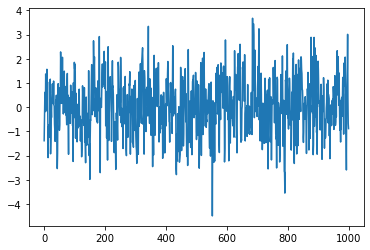

In [200]:
from statsmodels.tsa.arima_process import ArmaProcess

ar = np.array([1])
ma = np.array([1,0.5])
AR_object = ArmaProcess(ar,ma)
simulated_data = AR_object.generate_sample(nsample = 1000)
plt.plot(simulated_data)

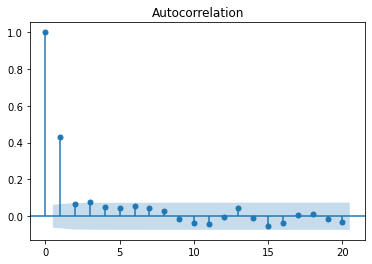

In [201]:
_=plot_acf(simulated_data,lags=20)

## Estimation and Forcasting and MA Model

In [202]:
mod = ARMA(simulated_data, order=(0,1))
res = mod.fit()
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1434.222
Method:                       css-mle   S.D. of innovations              1.015
Date:                Tue, 29 Dec 2020   AIC                           2874.443
Time:                        23:32:28   BIC                           2889.167
Sample:                             0   HQIC                          2880.039
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0240      0.049      0.489      0.625      -0.072       0.120
ma.L1.y        0.5294      0.027     19.714      0.000       0.477       0.582
                                    Roots           

Note the coefficient for the MA parameter is close to 0.5.

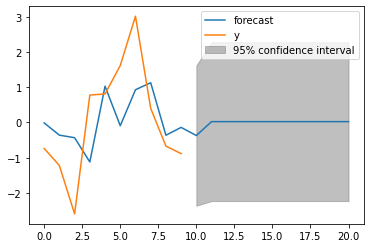

In [203]:
# Forecast the first MA(1) model
res.plot_predict(start=990, end=1010)
plt.show()

## Equivalence of AR(1) and MA($\infty$)

To better understand the relationship between MA models and AR models, you will demonstrate that an AR(1) model is equivalent to an MA() model with the appropriate parameters.

You will simulate an MA model with parameters 
 for a large number (30) lags and show that it has the same Autocorrelation Function as an AR(1) model with .

Note, to raise a number x to the power of an exponent n, use the format x**n.

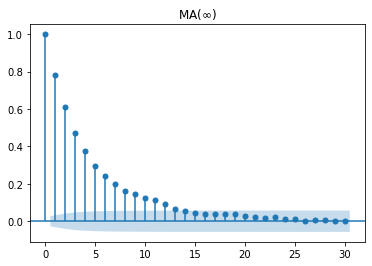

In [206]:
# Build a list MA parameters
ma = [0.8**i for i in range(30)]

# Simulate the MA(30) model
ar = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data = AR_object.generate_sample(nsample=5000)

# Plot the ACF
plot_acf(simulated_data, lags=30)
plt.title('MA($\infty$)')

Text(0.5, 1.0, 'AR(1)')

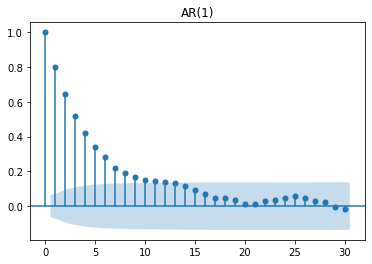

In [209]:
# Compare with AM(1) model

ar = np.array([1, -0.8])
ma = np.array([1])
AR_object = ArmaProcess(ar,ma)
simulated_data = AR_object.generate_sample(nsample=1000)
_=plot_acf(simulated_data,lags=30)
plt.title('AR(1)')

Notice that the ACF for MA($\infty$) looks the same as an AR(1) with parameter 0.8. 